In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from sklearn.preprocessing import LabelEncoder,StandardScaler
from scipy.stats import mode
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten


MultiLabel Classification

Loading the data

In [2]:

output_filepath = r'C:\Users\Shruti\Desktop\complex_Activity_dc\infowithlabels_with_acc.csv'  
final_data = pd.read_csv(output_filepath)
print(final_data.head())


       timestamp    ax     ay    az   gx   gy  gz Person      Activity  \
0  1621356793162 -1412 -15888  2180  160  111 -31     P0  brow-lowerer   
1  1621356793171 -1398 -15886  2221  140   91 -12     P0  brow-lowerer   
2  1621356793181 -1399 -15934  2275  137   82  13     P0  brow-lowerer   
3  1621356793191 -1398 -15977  2310  144   66  36     P0  brow-lowerer   
4  1621356793200 -1382 -16008  2347  159   49  47     P0  brow-lowerer   

  IMU_Side     Start_Time       End_Time  Activity_Label  
0     left  1621356572218  1621356793459               1  
1     left  1621356572218  1621356793459               1  
2     left  1621356572218  1621356793459               1  
3     left  1621356572218  1621356793459               1  
4     left  1621356572218  1621356793459               1  


In [3]:
columns=['Person','timestamp','ax','ay','az','gx','gy','gz','Activity']
final_data=final_data[columns]
print(final_data.head())

  Person      timestamp    ax     ay    az   gx   gy  gz      Activity
0     P0  1621356793162 -1412 -15888  2180  160  111 -31  brow-lowerer
1     P0  1621356793171 -1398 -15886  2221  140   91 -12  brow-lowerer
2     P0  1621356793181 -1399 -15934  2275  137   82  13  brow-lowerer
3     P0  1621356793191 -1398 -15977  2310  144   66  36  brow-lowerer
4     P0  1621356793200 -1382 -16008  2347  159   49  47  brow-lowerer


In [4]:
print(final_data.shape)

(13615277, 9)


Pre-processing

In [5]:
columns=['timestamp','ax','ay','az','gx','gy','gz','Activity']
final_data=final_data[columns]

In [6]:
final_data = final_data.sort_values(by='timestamp')
print(final_data.head())

            timestamp  ax     ay    az   gx  gy  gz Activity
301808  1621355241901  50 -15918  3820  100  23  -3    still
301809  1621355241911  47 -15934  3835  106  10  -4    still
301810  1621355241920  55 -15944  3843  110   0  -7    still
301811  1621355241930  47 -15947  3840  113 -19  -8    still
301812  1621355241940  43 -15943  3847  119 -42  -8    still


In [7]:
final_data.tail()

,timestamp,ax,ay,az,gx,gy,gz,Activity
10231976,1637343926368,-820,16697,-12120,-828,201,1372,running
10231977,1637343926378,-839,16035,-10958,-355,932,1081,running
10231978,1637343926388,-833,15951,-10608,-83,1013,655,running
10231979,1637343926397,-597,16189,-10796,-1,888,317,running
10231980,1637343926407,-225,16391,-10993,35,939,120,running


In [8]:
scaler = StandardScaler()
sensor_columns = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']
final_data[sensor_columns] = scaler.fit_transform(final_data[sensor_columns])

In [9]:
# Encode activity labels into integers
label_encoder = LabelEncoder()
final_data['Activity'] = label_encoder.fit_transform(final_data['Activity'])

In [10]:
def activities_at_timestamp(data, timestamp):
  
    # Filter the data for the given timestamp
    activities = data[data['timestamp'] == timestamp]['Activity'].unique()

    if len(activities) == 0:
        return f"No activities found at timestamp {timestamp}."
    return activities.tolist()


query_timestamp = 1637343934567 
result = activities_at_timestamp(final_data, query_timestamp)

print(f"Activities at timestamp {query_timestamp}: {result}")


Activities at timestamp 1637343934567: No activities found at timestamp 1637343934567.


At one timestamp there is one activity only.

In [11]:

# Constants
sampling_freq = 100
frame_size = 3 * sampling_freq  
step_size = 2 * sampling_freq   

segments = []
multi_label_activities = []

# Iterate through the data with a sliding window
for i in range(0, len(final_data) - frame_size, step_size):
    # Extract sensor data for the current window
    a_xs = final_data['ax'].values[i: i + frame_size]
    a_ys = final_data['ay'].values[i: i + frame_size]
    a_zs = final_data['az'].values[i: i + frame_size]
    g_xs = final_data['gx'].values[i: i + frame_size]
    g_ys = final_data['gy'].values[i: i + frame_size]
    g_zs = final_data['gz'].values[i: i + frame_size]

   
    segment_labels = final_data['Activity'][i: i + frame_size]
    unique_activities = list(set(segment_labels))
    
    # Convert to multi-label (each label in a binary form)
    multi_label = {activity: 1 if activity in unique_activities else 0 for activity in final_data['Activity'].unique()}
    
    segments.append([a_xs, a_ys, a_zs, g_xs, g_ys, g_zs])
    multi_label_activities.append(multi_label)


segments_array = np.array(segments)
X = segments_array.reshape(segments_array.shape[0], -1)  
y = pd.DataFrame(multi_label_activities)


In [12]:
print(X.shape)

(68075, 1800)


In [13]:
print(y.shape)

(68075, 18)


In [14]:
window_index = 89
window_labels = y.iloc[window_index]

active_labels = [label for label, is_active in window_labels.items() if is_active == 1]

print(f"Active labels in Window {window_index}: {active_labels}")


Active labels in Window 89: [12]


In [15]:
multi_label_count = 0
multi_label_windows = []

for idx, row in y.iterrows():
    active_labels = [label for label, is_active in row.items() if is_active == 1]
    if len(active_labels) > 1:
        multi_label_windows.append((idx, active_labels))
        multi_label_count += 1

if multi_label_windows:
    print(f"Total windows with more than one label: {multi_label_count}")
    for window_index, labels in multi_label_windows:
        print(f"Window {window_index}: {labels}")
else:
    print("No windows with more than one label.")


Total windows with more than one label: 4133
Window 124: [12, 8]
Window 125: [12, 8]
Window 250: [8, 10]
Window 298: [8, 10]
Window 299: [8, 10]
Window 300: [8, 10]
Window 301: [8, 10]
Window 376: [10, 14]
Window 502: [14, 5]
Window 627: [5, 4]
Window 628: [5, 4]
Window 690: [5, 4]
Window 691: [5, 4]
Window 692: [5, 4]
Window 693: [5, 4]
Window 753: [4, 1]
Window 754: [4, 1]
Window 792: [12, 1]
Window 793: [12, 1]
Window 801: [12, 1]
Window 802: [12, 1]
Window 879: [1, 0]
Window 880: [1, 0]
Window 1005: [0, 17]
Window 1030: [0, 17]
Window 1031: [0, 17]
Window 1032: [0, 17]
Window 1033: [0, 17]
Window 1130: [17, 16]
Window 1131: [17, 16]
Window 1167: [17, 16]
Window 1168: [17, 16]
Window 1169: [17, 16]
Window 1170: [17, 16]
Window 1257: [16, 6]
Window 1382: [6, 3]
Window 1384: [6, 3]
Window 1385: [6, 3]
Window 1386: [6, 3]
Window 1387: [6, 3]
Window 1508: [3, 7]
Window 1512: [3, 7]
Window 1513: [3, 7]
Window 1514: [3, 7]
Window 1515: [3, 7]
Window 1634: [7, 11]
Window 1759: [11, 13]
Win

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], frame_size, 6) 
X_test = X_test.reshape(X_test.shape[0], frame_size, 6)

In [17]:
X_train.shape

(54460, 300, 6)

In [18]:
X_test.shape

(13615, 300, 6)

Model Building

In [22]:
model = Sequential()

model.add(Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]))) 
model.add(MaxPooling1D(pool_size=2)) 

model.add(Conv1D(64, 3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(LSTM(100, return_sequences=False))  
model.add(Dropout(0.5))

model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1], activation='sigmoid'))  

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), verbose=1)
# applying a threshold of 0.5
y_pred = (model.predict(X_test) > 0.5).astype(int)


C:\Users\Shruti\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 46s 25ms/step - accuracy: 0.1568 - loss: 0.2262 - val_accuracy: 0.2820 - val_loss: 0.1771
Epoch 2/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 40s 23ms/step - accuracy: 0.2820 - loss: 0.1766 - val_accuracy: 0.3393 - val_loss: 0.1653
Epoch 3/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 40s 24ms/step - accuracy: 0.3550 - loss: 0.1620 - val_accuracy: 0.4405 - val_loss: 0.1449
Epoch 4/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.4426 - loss: 0.1435 - val_accuracy: 0.5387 - val_loss: 0.1251
Epoch 5/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 42s 24ms/step - accuracy: 0.5469 - loss: 0.1237 - val_accuracy: 0.6370 - val_loss: 0.1037
Epoch 6/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.6296 - loss: 0.1046 - val_accuracy: 0.6699 - val_loss: 0.0908
Epoch 7/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 44s 26ms/step - accuracy: 0.6605 - loss: 0.0967 - val_accuracy: 0.6897 - val_loss: 0.0866
Epoch 8/50
1702/1702 ━━━━━━━━━━━━━━━━━━━━ 45s 26ms/step - accuracy: 0.7136 -

In [23]:
from sklearn.metrics import f1_score
# Evaluate model performance
f1 = f1_score(y_test, y_pred, average='micro')
print(f'F1 Score: {f1:.4f}')


F1 Score: 0.8947


In [24]:
y_prob = model.predict(X_test)
threshold = 0.5

sample_index = 0  
sample_probabilities = y_prob[sample_index]

predicted_activities = [i for i, prob in enumerate(sample_probabilities) if prob > threshold]

print(f"--- Predicted Probabilities for Test Sample {sample_index} ---")
print(f"{'Class':<10}{'Probability':<15}")
print("-" * 30)

for i, prob in enumerate(sample_probabilities):
    print(f"{i:<10}{prob:<15.4f}")

print("\n--- Predicted Activities ---")
print(predicted_activities)


426/426 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step
--- Predicted Probabilities for Test Sample 0 ---
Class     Probability    
------------------------------
0         0.0011         
1         0.0001         
2         0.0206         
3         0.0009         
4         0.0000         
5         0.0144         
6         0.0020         
7         0.0009         
8         0.0001         
9         0.0002         
10        0.0027         
11        0.9810         
12        0.0005         
13        0.0002         
14        0.0018         
15        0.0000         
16        0.0000         
17        0.0002         

--- Predicted Activities ---
[11]


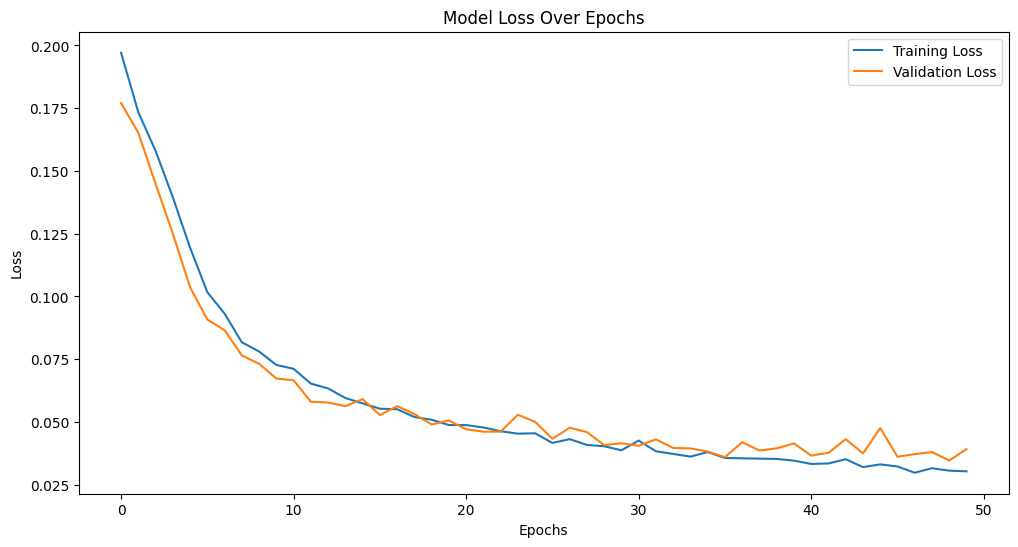

In [27]:
import matplotlib.pyplot as plt

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




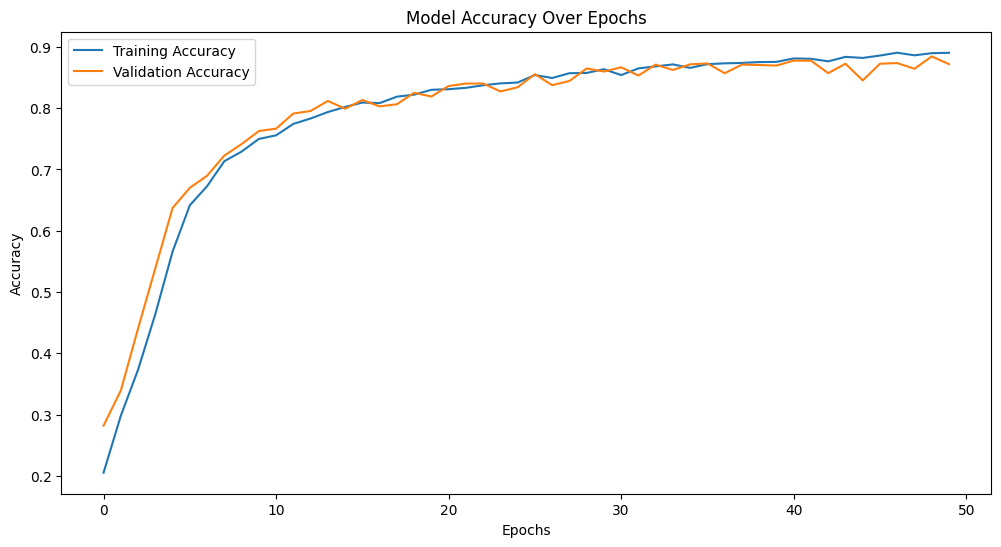

In [28]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()